# StackOverflow Analysis

## What criteria was used for subsampling?
From the word cloud generated I think the criteria used for Sub Sampling was to collect Posts related to Data Science. As the words that appear are Data Science Related Technologies and Terms.

### Import Modules
All the modules required are mentioned in requirements.txt

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pymongo
import re
counts = {}
post_count=0
user_dict={}

### Connect to Database

In [18]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["stackoverflow"]

## Generating a WordCloud

In [19]:
def add_cloud(text):
    text=text.lower()
    global counts
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    tokens = text.split()
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    for words in tokens: 
        if words not in stopwords: 
            comment_words = comment_words + words + ' '

    for word in comment_words.split():
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

def plot_cloud():
    global counts
    stopwords = set(STOPWORDS) 
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=1000,
                relative_scaling=0.21,
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(counts)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

In [20]:
def post_cloud_iterator(post_collection):
    global count
    count=0
    for post in post_collection.find():
        global post_count
        post_count+=1
        print(f'\r{post_count}',end=" ")
        if 'Body' in post.keys():
            cleanr=re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
            cleantext = re.sub(cleanr, '', post['Body'])
            add_cloud(' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",cleantext).split()))

3380602                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

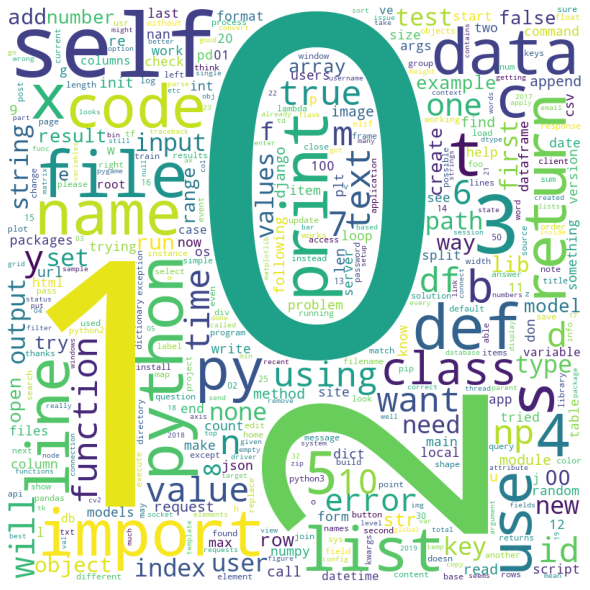

In [21]:
counts.clear()
post_count=0
post_cloud_iterator(mydb.Posts)
print("\n")
plot_cloud()


## Top 10 Occuring Tags
Here we find out the Top 10 Occuring Tags on StackOverlow. We loop through tag.xml to do this.

In [22]:
def prep_tags(Tags):
    tags={}
    tag_name=[]
    tag_count=[]
    for tag in Tags.find():
        if "TagName" in tag.keys():
            if "Count" in tag.keys():
                tags[tag["TagName"]]=int(tag["Count"])
    tags={k: v for k, v in sorted(tags.items(), key=lambda item: item[1], reverse=True)}
    for tag,tagcount in tags.items():
        tag_name.append(tag)
        tag_count.append(tagcount)
    fig = plt.figure()
    plt.bar(tag_name[:11],tag_count[:11],color=['red', 'black', 'green', 'orange', 'blue','yellow','violet','cyan','pink','magenta'])
    plt.show()

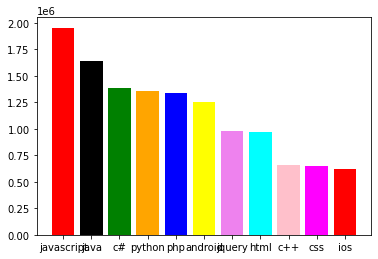

In [23]:
prep_tags(mydb.Tags)

## Analysis of Reputation vs Skill
StackOverflow uses a metric called Reputation for each user. It is number specifying the useful contributions of a user on StackOverlow. This metric results in the gamification of the site. We can analyse the relation between Reputation and Skill level of a user using [Elo_rating_system](https://en.wikipedia.org/wiki/Elo_rating_system). Each question is seen as a "game", the responders were seen as "players" and the outcome of each game was determined by the votes. The players skill was then estimated using the Elo rating system. Initially everyone was given a skill of 1500 and the game was started. When a user answers a question, his/her skill will get a positive update if the answer gets more upvotes than the other answers on the same question, and a negative update if it gets less upvotes. The magnitude of the skill update is determined by the reputation of the other users and whether or not the outcome was expected. I used the absolute difference in reputation as the metric for seeing if it is expected or not and updated accordingly.
Because the process takes a lot of computing power I did the study for a random set of 5000 posts from the database
**X-Axis is Skill and Y-Axis is Reputation**
### Observations Made
- Reputation and Skill shows a Relation.
- Users with high reputation have high skill level as expected.
- Most of the Stack Overflow Users have similar skill level and they have similar reputations ( Cluster in plot)
- A low reputed user can be skilled or un-skilled

In [24]:
def skills(Users, Posts):
    global user_dict
    user_dict.clear()
    selected_ids=set()
    selectedUsers=[]
    for user in Users.find():
        if "Reputation" in user.keys():
            user_dict[user["Id"]]=[int(user["Reputation"]),1500]
    j=0
    for post in Posts.aggregate([{ "$match": { "PostTypeId": "1" } },{ "$sample": { "size": 5000} }]):
        if (post["Id"] in selected_ids):
            continue
        selected_ids.add(post["Id"])

        j+=1
        print(f'\r{j}', end=" ")
        if "PostTypeId" in post.keys():
            if post["PostTypeId"]=="1":
                ans=[]
                for reply in Posts.find({"ParentId":post["Id"]}):
                    ans.append(reply)
                ans=sorted(ans, key = lambda i: int(i['Score']),reverse=True)
                #print(len(ans))
                if(len(ans)>=2):
                    if "OwnerUserId" in ans[0].keys():
                        selectedUsers.append(ans[0]["OwnerUserId"])
                    for i in range(1,len(ans)):
                        if ("OwnerUserId" in ans[i].keys() and "OwnerUserId" in ans[0].keys()):
                            user_dict[ans[i]["OwnerUserId"]][1]-= abs(int(user_dict[ans[i]["OwnerUserId"]][0])-int(user_dict[ans[0]["OwnerUserId"]][0]))
                            user_dict[ans[0]["OwnerUserId"]][1]+= abs(int(user_dict[ans[i]["OwnerUserId"]][0])-int(user_dict[ans[0]["OwnerUserId"]][0]))
                            selectedUsers.append(ans[i]["OwnerUserId"])
    reputation_plots=[]
    skill_plots=[]
    print("No. of Users Analysed:", len(selectedUsers))
    for user in selectedUsers:
        reputation_plots.append(user_dict[user][0])
        skill_plots.append(user_dict[user][1])
    plt.scatter(skill_plots, reputation_plots)
    plt.show()

5000 No. of Users Analysed: 5291


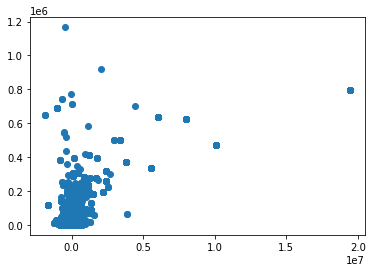

In [25]:
skills(mydb.Users,mydb.Posts)

## Top 10 Least Occuring Tags
By looking at the top 10 least occuring tags we can see a relation. The community doesn't like vague topics and tags.

In [26]:
def prep_tags_reverse(Tags):
    tags={}
    tag_name=[]
    tag_count=[]
    tags.clear()
    for tag in Tags.find():
        if "TagName" in tag.keys():
            if "Count" in tag.keys():
                tags[tag["TagName"]]=int(tag["Count"])
    tags={k: v for k, v in sorted(tags.items(), key=lambda item: item[1])}
    for tag,tagcount in tags.items():
        tag_name.append(tag)
        tag_count.append(tagcount)
    fig = plt.figure()
    plt.bar(tag_name[:11],tag_count[:11],color=['red', 'black', 'green', 'orange', 'blue','yellow','violet','cyan','pink','magenta'])
    plt.show()

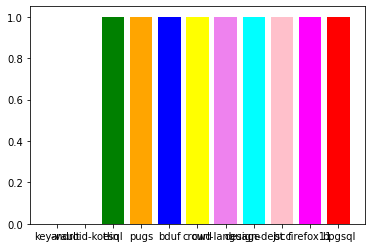

In [27]:
prep_tags_reverse(mydb.Tags)

## Top 10 Badges

In [30]:
def prep_Badges(Badges):
    badges={}
    bg_name=[]
    bg_count=[]
    badges.clear()
    for badge in Badges.find():
        if "Name" in badge.keys():
            if badge["Name"] in badges.keys():
                badges[badge["Name"]]+=1
            else:
                badges[badge["Name"]]=1
                
    badges={k: v for k, v in sorted(badges.items(), key=lambda item: item[1],reverse=True)}
    for bg,bgcount in badges.items():
        bg_name.append(bg)
        bg_count.append(bgcount)
    fig = plt.figure()
    plt.bar(bg_name[:11],bg_count[:11],color=['red', 'black', 'green', 'orange', 'blue','yellow','violet','cyan','pink','magenta'])
    plt.show()

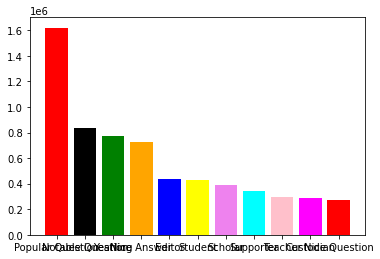

In [31]:
prep_Badges(mydb.Badges)

In [32]:
myclient.close()